In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import models
import os
import argparse

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
import pandas as pd
from torchsummary import summary
from torchmetrics import F1Score
#from pytorchtools import EarlyStopping
import time
import copy
import glob
from PIL import Image
import datetime

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--aff_path', type=str, default='datasets/AfectNet/', help='AfectNet dataset path.')
parser.add_argument('--batch_size', type=int, default=64, help='Batch size.')
parser.add_argument('--lr', type=float, default=0.0001, help='Initial learning rate for adam.')
parser.add_argument('--workers', default=8, type=int, help='Number of data loading workers.')
parser.add_argument('--epochs', type=int, default=40, help='Total training epochs.')
parser.add_argument('--num_head', type=int, default=4, help='Number of attention head.')
parser.add_argument('--num_class', type=int, default=2, help='Number of class.')

args = parser.parse_args(args = [])

In [4]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [5]:
class ImbalancedDatasetSampler(data.sampler.Sampler):
    def __init__(self, dataset, indices: list = None, num_samples: int = None):
        self.indices = list(range(len(dataset))) if indices is None else indices
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

        # self.weights = self.weights.clamp(min=1e-5)

    def _get_labels(self, dataset):
        if isinstance(dataset, datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torch.utils.data.Subset):
            return [dataset.dataset.imgs[i][1] for i in dataset.indices]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [6]:
# define transformation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.RandomAffine(20, scale = (0.8, 1), translate = (0.2, 0.2)),], p = 0.7),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225]),
    transforms.RandomErasing(),
])

# train_dataset
train_dataset = datasets.ImageFolder('./datasets/AfectNet/train/pos', transform = data_transforms)
if args.num_class == 3:
    idx = [i for i in range(len(train_dataset)) if train_dataset.imgs[i][1] != 7]
    train_dataset = data.Subset(train_dataset, idx)
    
print('Whole train set size:', train_dataset.__len__())
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size = args.batch_size,
                                          num_workers = args.workers,
                                          sampler = ImbalancedDatasetSampler(train_dataset),
                                          shuffle = False,
                                          pin_memory = True)

Whole train set size: 60000


In [7]:
data_transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
])

# val_dataset
val_dataset = datasets.ImageFolder('./datasets/AfectNet/val/pos', transform = data_transforms_val)
if args.num_class == 3:
    idx = [i for i in range(len(val_dataset)) if val_dataset.imgs[i][1] != 7]
    val_dataset = data.Subset(val_dataset, idx)
    
print('Validation set size:', val_dataset.__len__())

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = args.batch_size,
    num_workers = args.workers,
    shuffle = False,
    pin_memory = True
)

Validation set size: 1250


In [8]:
# Swish actiavtion function
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return x * self.sigmoid(x)
    
# # check
# if __name__ == '__main__':
#     x = torch.randn(3, 3, 224, 224)
#     model = Swish()
#     output = model(x)
#     print('output size:', output.size())

In [9]:
# SE Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, r = 4):
        super().__init__()
        
        self.squeeze = nn.AdaptiveAvgPool2d((1, 1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // r),
            Swish(),
            nn.Linear(in_channels // r, in_channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x
    
# # chech
# if __name__ == '__main__':
#     x = torch.randn(3, 56, 17, 17)
#     model = SEBlock(x.size(1))
#     output = model(x)
#     print('output size:', output.size())

In [10]:
class MBConv(nn.Module):
    expand = 6
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first MBConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish(),
            nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * MBConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

# # check
# if __name__ == '__main__':
#     x = torch.randn(3, 16, 24, 24)
#     model = MBConv(x.size(1), x.size(1), 3, stride=1, p=1)
#     model.train()
#     output = model(x)
#     x = (output == x)
#     print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

In [11]:
class SepConv(nn.Module):
    expand = 1
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first SepConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
            nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * SepConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

# # check
# if __name__ == '__main__':
#     x = torch.randn(3, 16, 24, 24)
#     model = SepConv(x.size(1), x.size(1), 3, stride=1, p=1)
#     model.train()
#     output = model(x)
#     # stochastic depth check
#     x = (output == x)
#     print('output size:', output.size(), 'Stochastic depth:', x[1,0,0,0])

In [12]:
class EfficientNet(nn.Module):
    def __init__(self, num_classes=2, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
        super().__init__()
        channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        repeats = [1, 2, 2, 3, 3, 4, 1]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_size = [3, 3, 5, 3, 5, 5, 3]
        depth = depth_coef
        width = width_coef

        channels = [int(x*width) for x in channels]
        repeats = [int(x*depth) for x in repeats]

        # stochastic depth
        if stochastic_depth:
            self.p = p
            self.step = (1 - 0.5) / (sum(repeats) - 1)
        else:
            self.p = 1
            self.step = 0


        # efficient net
        self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

        self.stage1 = nn.Sequential(
            nn.Conv2d(3, channels[0],3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
        )

        self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)

        self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)

        self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)

        self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)

        self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)

        self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)

        self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)

        self.stage9 = nn.Sequential(
            nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
            nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
            Swish()
        ) 

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(channels[8], num_classes)

    def forward(self, x):
        #x = x.type(torch.float16)
        x = self.upsample(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.stage8(x)
        x = self.stage9(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x


    def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
        strides = [stride] + [1] * (repeats - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
            in_channels = out_channels
            self.p -= self.step

        return nn.Sequential(*layers)


def efficientnet_b0(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=2):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)


# # check
# if __name__ == '__main__':
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     x = torch.randn(3, 3, 224, 224).to(device)
#     model = efficientnet_b0().to(device)
#     output = model(x)
#     print('output size:', output.size())

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18

from torchcam.methods import GradCAM, GradCAMpp, SmoothGradCAMpp, XGradCAM, LayerCAM
from torchcam.utils import overlay_mask

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pos_model = torch.load('./models_b2/pos_weights_all.pt', map_location = device)
neg_model = torch.load('./models_b2/neg_weights_all.pt', map_location = device)
print(pos_model)

EfficientNet(
  (upsample): Upsample(scale_factor=1.1607142857142858, mode=bilinear)
  (stage1): Sequential(
    (0): Conv2d(3, 35, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(35, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  )
  (stage2): Sequential(
    (0): SepConv(
      (residual): Sequential(
        (0): Conv2d(35, 35, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=35, bias=False)
        (1): BatchNorm2d(35, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): Swish(
          (sigmoid): Sigmoid()
        )
      )
      (se): SEBlock(
        (squeeze): AdaptiveAvgPool2d(output_size=(1, 1))
        (excitation): Sequential(
          (0): Linear(in_features=35, out_features=8, bias=True)
          (1): Swish(
            (sigmoid): Sigmoid()
          )
          (2): Linear(in_features=8, out_features=35, bias=True)
          (3): Sigmoid()
        )
      )
      (project): Seque

In [15]:
def cam_extract(pos_model, neg_model, file_name):
    img_path = './datasets/AfectNet/train/1/' + file_name
    pil_img = Image.open(img_path)
    img = read_image(img_path).to(device)
    
    input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    pos_cam_ext = LayerCAM(pos_model, ['stage1', 'stage2', 'stage3', 'stage4', 'stage5', 'stage6', 'stage7', 'stage8'])
    neg_cam_ext = LayerCAM(neg_model, ["stage1", "stage2", "stage3", "stage4", "stage5", "stage6", "stage7", "stage8"])
    
    pos_out = pos_model(input_tensor.unsqueeze(0))
    neg_out = neg_model(input_tensor.unsqueeze(0))
    
    pos_cams = pos_cam_ext(pos_out.squeeze(0).argmax().item(), pos_out)
    neg_cams = neg_cam_ext(neg_out.squeeze(0).argmax().item(), neg_out)
    
    pos_fused_cam = pos_cam_ext.fuse_cams(pos_cams)
    neg_fused_cam = neg_cam_ext.fuse_cams(neg_cams)
    
    pos_result = overlay_mask(to_pil_image(img), to_pil_image(pos_fused_cam, mode = 'F'), alpha = 0.5)
    neg_result = overlay_mask(to_pil_image(img), to_pil_image(neg_fused_cam, mode = 'F'), alpha = 0.5)
    
    plt.imshow(pos_result)
    plt.savefig(f'./result/posmodel_pos_img/{file_name[: -4]}_pos_LayerCAM.jpg')
    
    #plt.imshow(neg_result)
    #plt.savefig(f'./result/negmodel_pos_img/{file_name[:-4]}_neg_LayerCAM.jpg')
    
    pos_cam_ext.remove_hooks()
    neg_cam_ext.remove_hooks()

0.jpg
10.jpg
100000.jpg
100001.jpg
100004.jpg
100011.jpg
100015.jpg
100017.jpg
10002.jpg
100020.jpg
100022.jpg
100024.jpg
10003.jpg
100033.jpg
100034.jpg
100037.jpg
100038.jpg
10004.jpg
100043.jpg
100046.jpg
100049.jpg
100051.jpg
100059.jpg
100062.jpg
100065.jpg
100066.jpg
100068.jpg
100069.jpg
100072.jpg
100081.jpg
100082.jpg
100089.jpg
100090.jpg
100095.jpg
100096.jpg
1001.jpg
10010.jpg
100102.jpg
100104.jpg
100108.jpg
100109.jpg
100111.jpg
100116.jpg
100118.jpg
100120.jpg
100121.jpg
100122.jpg
100125.jpg
100129.jpg
100131.jpg
100139.jpg
100140.jpg
100144.jpg
100145.jpg
100152.jpg
100159.jpg
100160.jpg
100163.jpg
100165.jpg
100169.jpg
100171.jpg
100173.jpg
100176.jpg
100183.jpg
100187.jpg
100189.jpg
100192.jpg
100193.jpg
1002.jpg
100201.jpg
100204.jpg
100205.jpg
100206.jpg
100207.jpg
100208.jpg
100209.jpg
10021.jpg
100211.jpg
100214.jpg
100217.jpg
100222.jpg
100225.jpg
100226.jpg
100231.jpg
100233.jpg
100237.jpg
10024.jpg
100240.jpg
100241.jpg
100242.jpg
100247.jpg
100249.jpg
100250.

KeyboardInterrupt: 

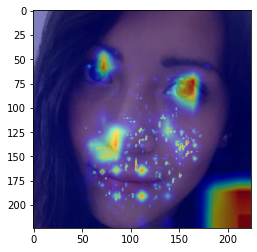

In [16]:
file_dir = './datasets/AfectNet/train/1'
file_names = os.listdir(file_dir)
for file in file_names:
    print(file)
    cam_extract(pos_model, neg_model, file)

In [ ]:
# #img_path = './datasets/AfectNet/train_og/0/0_14.jpg'
# img_path = './datasets/AfectNet/train_og/0/0_281.jpg'
# pil_img = Image.open(img_path)
# pil_img

In [ ]:
# pos_cam_extractor = SmoothGradCAMpp(pos_model)
# neg_cam_extractor = SmoothGradCAMpp(neg_model)

In [ ]:
# Get your input
# img = read_image(img_path).to(device)

In [ ]:
# Preprocess it for your chosen model
# input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
# # Preprocess your data and feed it to the model
# pos_out = pos_model(input_tensor.unsqueeze(0))
# neg_out = neg_model(input_tensor.unsqueeze(0))
# #print(pos_out, neg_out, input_tensor.unsqueeze(0))

In [ ]:
# # Retrieve the CAM by passing the class index and the model output
# pos_cams = pos_cam_extractor(pos_out.squeeze(0).argmax().item(), pos_out)
# neg_cams = neg_cam_extractor(neg_out.squeeze(0).argmax().item(), neg_out)

In [ ]:
# for cam in pos_cams:
#     print(cam.shape)

In [ ]:
# for cam in neg_cams:
#     print(cam.shape)

In [ ]:
# for name, cam in zip(pos_cam_extractor.target_names, pos_cams):
#     plt.imshow(cam.squeeze(0).cpu().numpy()); plt.axis('off'); plt.title(name); 
#     #plt.show()
#     plt.savefig('./results/0_281_pos_cam1.jpg')

In [ ]:
# for name, cam in zip(neg_cam_extractor.target_names, neg_cams):
#     plt.imshow(cam.squeeze(0).cpu().numpy()); plt.axis('off'); plt.title(name)
#     #plt.show()
#     plt.savefig('./results/0_281_neg_cam1.jpg')

In [ ]:
# for name, cam in zip(pos_cam_extractor.target_names, pos_cams):
#     result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode = 'F'), alpha = 0.5)
#     plt.imshow(result); plt.axis('off'); plt.title(name); 
#     #plt.show(); 
#     plt.savefig('./results/0_281_pos_cam2.jpg')

In [ ]:
# for name, cam in zip(neg_cam_extractor.target_names, neg_cams):
#     result = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode = 'F'), alpha = 0.5)
#     plt.imshow(result); plt.axis('off'); plt.title(name)
#     #plt.show()
#     plt.savefig('./results/0_281_neg_cam2.jpg')

In [ ]:
# pos_cam_extractor.remove_hooks()
# neg_cam_extractor.remove_hooks()

In [ ]:
# # Retrieve the CAM from several layers at the same time
# cam_extractor = LayerCAM(pos_model)

# # Preprocess your data and feed it to the model
# out = pos_model(input_tensor.unsqueeze(0))
# print(softmax(out, dim=1).max())

In [ ]:
# cams = cam_extractor(out.squeeze(0).argmax().item(), out)

In [ ]:
# # Resize it
# resized_cams = [resize(to_pil_image(cam.squeeze(0)), img.shape[-2:]) for cam in cams]
# segmaps = [to_pil_image((resize(cam, img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# # Plot it
# for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
#   _, axes = plt.subplots(1, 2)
#   axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
#   axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
#   plt.show()

In [ ]:
# Once you're finished, clear the hooks on your model
# cam_extractor.remove_hooks()

In [ ]:
# # Retrieve the CAM from several layers at the same time
# pos_cam_extractor = LayerCAM(pos_model, ["stage1", "stage2", "stage3", "stage4", "stage5", "stage6", "stage7", "stage8"])

# # Preprocess your data and feed it to the model
# out = pos_model(input_tensor.unsqueeze(0))
# # Retrieve the CAM by passing the class index and the model output
# cams = pos_cam_extractor(out.squeeze(0).argmax().item(), out)

# # Let's fuse them
# fused_cam = pos_cam_extractor.fuse_cams(cams)
# # Plot the raw version
# plt.imshow(fused_cam.squeeze(0).cpu().numpy()); plt.axis('off')
# #plt.title(" + ".join(pos_cam_extractor.target_names))
# plt.savefig('./results/0_281_pos_cam_extractor.jpg')
# # Plot the overlayed version
# result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
# plt.imshow(result); plt.axis('off')
# #plt.title(" + ".join(pos_cam_extractor.target_names))
# plt.savefig('./results/0_281_pos_cam_extractor_layered.jpg')

In [ ]:
# # This time, there are several CAMs
# for cam in cams:
#   print(cam.shape)

In [ ]:
# # The raw CAM
# _, axes = plt.subplots(len(pos_cam_extractor.target_names), 1)
# for idx, name, cam in zip(range(len(pos_cam_extractor.target_names)), pos_cam_extractor.target_names, cams):
    
#   axes[idx].imshow(cam.squeeze(0).cpu().numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
# #plt.show(); 
# #plt.savefig(f'./results/0_112_pos_cam_stage{name}.jpg')

In [ ]:
# # Retrieve the CAM from several layers at the same time
# neg_cam_extractor = LayerCAM(neg_model, ["stage1", "stage2", "stage3", "stage4", "stage5", "stage6", "stage7", "stage8"])

# # Preprocess your data and feed it to the model
# out = neg_model(input_tensor.unsqueeze(0))
# # Retrieve the CAM by passing the class index and the model output
# cams = neg_cam_extractor(out.squeeze(0).argmax().item(), out)

# # # The raw CAM
# # _, axes = plt.subplots(len(neg_cam_extractor.target_names), 1)
# # for idx, name, cam in zip(range(len(neg_cam_extractor.target_names)), neg_cam_extractor.target_names, cams):
    
# #   axes[idx].imshow(cam.squeeze(0).cpu().numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
# # #plt.show(); 
# # #plt.savefig(f'./results/0_112_pos_cam_stage{name}.jpg')

# # Let's fuse them
# fused_cam = neg_cam_extractor.fuse_cams(cams)
# # Plot the raw version
# plt.imshow(fused_cam.squeeze(0).cpu().numpy()); plt.axis('off')
# #plt.title(" + ".join(neg_cam_extractor.target_names))
# plt.savefig('./results/0_281_neg_cam_extractor.jpg')
# # Plot the overlayed version
# result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
# plt.imshow(result); plt.axis('off')
# #plt.title(" + ".join(neg_cam_extractor.target_names))
# plt.savefig('./results/0_281_neg_cam_extractor_layered.jpg')


In [ ]:
# # Let's fuse them
# fused_cam = neg_cam_extractor.fuse_cams(cams)
# # Plot the raw version
# plt.imshow(fused_cam.squeeze(0).cpu().numpy()); plt.axis('off'); plt.title(" + ".join(neg_cam_extractor.target_names)); plt.show()
# # Plot the overlayed version
# result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.5)
# plt.imshow(result); plt.axis('off')
# #plt.title(" + ".join(neg_cam_extractor.target_names))
# plt.savefig('./results/0_1_neg_cam_extractor.jpg')
